# Working with databases from IPython

This is a small example of using Pandas to create, connect to, and query a database

Lets start by creating a database (using sqlite) and try some queries

## Creating a toy database

From the command line, let's create a new sqlite3 database named `sdss.db`:
```bash
$ sqlite3 sdss.db
```

This will open a `sqlite>` prompt. Now let's create the tables by running
the following on the sqlite prompt:

```sql
sqlite> CREATE TABLE sources (
    run         INTEGER,
    rerun       INTEGER,
    camcol      INTEGER,
    field       INTEGER,
    obj         INTEGER,
    type        INTEGER,
    ra          REAL,
    dec         REAL,
    psfMag_r    REAL,
    psfMag_g    REAL,
    psfMgErr_r  REAL,
    psfMagErr_g REAL
);

sqlite> CREATE TABLE runs (
    run         INTEGER,
    ra          REAL,
    dec         REAL,
    mjdstart    REAL,
    mjdend      REAL,
    node        REAL,
    inclination REAL,
    mu0    REAL,
    nu0    REAL
);


To find the sqlite commands

sqlite> .help

To see what we have created look at the tables we have created

sqlite> .tables

To see the structure (schema) of these tables

sqlite> .schema

sqlite> .quit
```

Don't forget the semicolons at the end!

We need to massage the input data a bit before we can load them. In
particular, sqlite won't know how to load data that begin with a header, so
we'll just remove it manually. Do:

```bash
cp runs.txt runs.in
# And then edit runs.in to remove the first line (the header)

cp sample.csv sample.txt
# And then edit sample.txt to remove the first line
```

Let's go back into sqlite, to do the import:
```sql
sqlite sdss.db

sqlite> .mode csv
sqlite> .separator " "
sqlite> .import runs.in runs
sqlite> .separator ","
sqlite> .import sample.txt sources
sqlite> .quit
```

At this point, you have a database with two tables. You can open and view it
in sqlitebrowser (https://sqlitebrowser.org/dl/).

For those on a Mac: The first time you run sqlite browser, you may need to
right-click then select ‘Open’ while holding down the Option key.  This is
to circumvent Mac's security requirement for signed binaries. Note: do not
do this unless you trust the binary; being careful about security is good!

## Practicing basic SQL

Now let's practice some SQL queries:
```sql
SELECT ra, dec, psfMag_r FROM sources
SELECT ra, dec, psfMag_r FROM sources WHERE psfMag_r < 21.5
SELECT ra, dec, psfMag_r FROM sources WHERE psfMag_r < 21.5 LIMIT 5
SELECT COUNT(psfMag_r), AVG(psfMag_r) FROM sources WHERE psfMag_r < 21.5
SELECT COUNT(*), run FROM sources GROUP BY run
SELECT COUNT(*), run FROM sources GROUP BY run ORDER BY run
SELECT COUNT(*) as ct , run FROM sources GROUP BY run ORDER BY ct
```

## Practicing SQL Joins

This query joins the data from two tables (sources and runs):

```sql
SELECT
  sources.ra, sources.dec, sources.run, mjdstart
FROM
  sources JOIN runs ON sources.run = runs.run
```

In [1]:
import pandas as pd
import numpy as np
import sqlite3

This deletes the database file, if it exists. It's to ensure we're starting from scratch

In [2]:
import os
try:
    os.remove("msdss.db")
except OSError:
    pass

Connect to ("open") our SQLite database. If we were dealing with (for example) a MySQL database, this would make a connection to a MySQL server (that may be local to your machine, but also (more likely) somewhere else, on a remote server).

If the database doesn't exist, SQLite's behavior is to automatically create it.

## Importing data

In [3]:
con = sqlite3.connect("msdss.db")

Now we'll create the tables. The backticks -- the \` characters -- are a way to quote names in SQLite's dialect of SQL. They're not strictly necessary here (they would be if, say, you wanted to name the table "my sources", i.e., have a whitespace as a part of the name)

In [4]:
con.execute("""
CREATE TABLE `sources` (
    `run`      INTEGER,
    `rerun`    INTEGER,
    `camcol`   INTEGER,
    `field`    INTEGER,
    `obj`      INTEGER,
    `type`     INTEGER,

    `ra`          REAL,
    `dec`         REAL,
    `psfMag_r`    REAL,
    `psfMag_g`    REAL,
    `psfMagErr_r` REAL,
    `psfMagErr_g` REAL
);
""")

In [5]:
con.execute("""
CREATE TABLE `runs` (
    `run`         INTEGER,
    `ra`          REAL,
    `dec`         REAL,
    `mjdstart`    REAL,
    `mjdend`      REAL,
    `node`        REAL,
    `inclination` REAL,
    `mu0`         REAL,
    `nu0`         REAL
);
""")

Here we use pandas' `read_cvs` function to read the `runs.txt` file into memory. This is very similar to `np.genfromtxt` and `np.loadtext`, but much more powerful. See the documentation for details.

One particular thing to note is the `index_col` keyword. It tells Pandas which column can be used to uniquely refer to any row.

In [42]:
runs = pd.read_csv('runs.txt', 
            sep=" ", header=None, skiprows=1, 
            names=['run', 'ra', 'dec', 'mjdstart', 'mjdend', 'node', 'inclination', 'mu0', 'nu0'],
            index_col = 'run')

Pandas loaded the contents of `runs.txt` into its own data structure called a `DataFrame`. For now, think of a data frame as a table.

In [43]:
type(runs)

pandas.core.frame.DataFrame

You can generally use a `DataFrame` the same way you'd use a numpy array (i.e., subscripting and slicing works)

In [44]:
runs[:5]

,ra,dec,mjdstart,mjdend,node,inclination,mu0,nu0
run,,,,,,,,
94,336.432779,-1.044294,51075.233211,51075.455014,286.855205,0.009477,336.432667,-1.051509
109,396.241809,-1.250557,51078.390783,51078.474944,283.391747,0.008279,36.241879,-1.258186
125,350.469743,-1.252750,51081.255759,51081.495289,287.818732,0.007781,350.469664,-1.259661
211,402.581109,-1.265170,51115.307000,51115.462055,283.219780,0.007975,42.581196,-1.272121
240,375.189678,-1.264403,51132.185032,51132.248851,290.578187,0.010103,15.189657,-1.274462


Pandas does its best to infer the correct data types for the data in the file. Let's see what it did for this file:

In [9]:
runs.dtypes

ra             float64
dec            float64
mjdstart       float64
mjdend         float64
node           float64
inclination    float64
mu0            float64
nu0            float64
dtype: object

Now, let's load the sources:

In [29]:
sources = pd.read_csv('sample.csv', index_col=['run', 'rerun', 'camcol', 'field', 'obj'])

In [30]:
sources.dtypes

type             int64
ra             float64
dec            float64
psfMag_r       float64
psfMag_g       float64
psfMagErr_r    float64
psfMagErr_g    float64
dtype: object

You can be explicit about column datatypes:

In [31]:
sources = pd.read_csv('sample.csv',
                        dtype={
                                'run': np.int16,
                                'rerun': np.int16,
                                'camcol': np.int8,
                                'field': np.int16,
                                'obj':  np.int32,
                                'type': np.int16,
                                'psfMag_r': np.float32,
                                'psfMag_g': np.float32,
                                'psfMagErr_r': np.float32,
                                'psfMagErr_g': np.float32,
                              },
                        index_col=['run', 'rerun', 'camcol', 'field', 'obj'])

In [32]:
sources.dtypes

type             int16
ra             float64
dec            float64
psfMag_r       float32
psfMag_g       float32
psfMagErr_r    float32
psfMagErr_g    float32
dtype: object

Can we deal with missing data?

In [33]:
sources[sources["psfMagErr_g"] < 0][:5]

type          ra        dec  psfMag_r  psfMag_g  \
run  rerun camcol field obj                                                     
3366 301   1      80    3009     0   12.231521  41.113295   -9999.0   -9999.0   
                        3010     0   12.082267  41.206067   -9999.0   -9999.0   
                        3011     0   12.184899  41.142380   -9999.0   -9999.0   
3996 301   1      162   1413     0  228.319441   9.958091   -9999.0   -9999.0   
4894 301   1      174   592      0  352.075004  -0.932815   -9999.0   -9999.0   

                              psfMagErr_r  psfMagErr_g  
run  rerun camcol field obj                             
3366 301   1      80    3009      -9999.0      -9999.0  
                        3010      -9999.0      -9999.0  
                        3011      -9999.0      -9999.0  
3996 301   1      162   1413      -9999.0      -9999.0  
4894 301   1      174   592       -9999.0      -9999.0

In [34]:
sources = pd.read_csv('sample.csv',
                        dtype={
                                'run': np.int16,
                                'rerun': np.int16,
                                'camcol': np.int8,
                                'field': np.int16,
                                'obj':  np.int32,
                                'type': np.int16,
                                'psfMag_r': np.float32,
                                'psfMag_g': np.float32,
                                'psfMagErr_r': np.float32,
                                'psfMagErr_g': np.float32,
                              },
                        index_col=['run', 'rerun', 'camcol', 'field', 'obj'],
                        na_values=["-9999"])

No more -9999s!

In [37]:
sources[sources["psfMagErr_g"] < 0][:5]

,,,,,type,ra,dec,psfMag_r,psfMag_g,psfMagErr_r,psfMagErr_g
run,rerun,camcol,field,obj,,,,,,,


Now there are NaNs:

In [38]:
sources[sources["psfMagErr_g"].isnull()][:5]

type          ra        dec  psfMag_r  psfMag_g  \
run  rerun camcol field obj                                                     
3366 301   1      80    3009     0   12.231521  41.113295       NaN       NaN   
                        3010     0   12.082267  41.206067       NaN       NaN   
                        3011     0   12.184899  41.142380       NaN       NaN   
3996 301   1      162   1413     0  228.319441   9.958091       NaN       NaN   
4894 301   1      174   592      0  352.075004  -0.932815       NaN       NaN   

                              psfMagErr_r  psfMagErr_g  
run  rerun camcol field obj                             
3366 301   1      80    3009          NaN          NaN  
                        3010          NaN          NaN  
                        3011          NaN          NaN  
3996 301   1      162   1413          NaN          NaN  
4894 301   1      174   592           NaN          NaN

Let's be a bit more specific about where -9999 is to be considered as a marker for missing data:

In [45]:
sources = pd.read_csv('sample.csv',
                        dtype={
                                'run': np.int16,
                                'rerun': np.int16,
                                'camcol': np.int8,
                                'field': np.int16,
                                'obj':  np.int32,
                                'type': np.int16,
                                'psfMag_r': np.float32,
                                'psfMag_g': np.float32,
                                'psfMagErr_r': np.float32,
                                'psfMagErr_g': np.float32,
                              },
                       index_col=['run', 'rerun', 'camcol', 'field', 'obj'],
                       na_values={
                            'psfMagErr_g': ["-9999"],
                            'psfMagErr_r': ["-9999"],
                            'psfMag_g': ["-9999"],
                            'psfMag_r': ["-9999"],
                       },
                       verbose=True
                     )

Tokenization took: 51.43 ms
Type conversion took: 54.77 ms
Parser memory cleanup took: 0.03 ms


In [46]:
sources[sources["psfMagErr_g"].isnull()][:5]

type          ra        dec  psfMag_r  psfMag_g  \
run  rerun camcol field obj                                                     
3366 301   1      80    3009     0   12.231521  41.113295       NaN       NaN   
                        3010     0   12.082267  41.206067       NaN       NaN   
                        3011     0   12.184899  41.142380       NaN       NaN   
3996 301   1      162   1413     0  228.319441   9.958091       NaN       NaN   
4894 301   1      174   592      0  352.075004  -0.932815       NaN       NaN   

                              psfMagErr_r  psfMagErr_g  
run  rerun camcol field obj                             
3366 301   1      80    3009          NaN          NaN  
                        3010          NaN          NaN  
                        3011          NaN          NaN  
3996 301   1      162   1413          NaN          NaN  
4894 301   1      174   592           NaN          NaN

Now, store this into our database

In [48]:
runs.to_sql?

In [47]:
runs.to_sql('runs', con, if_exists='append')

In [49]:
sources.to_sql('sources', con, if_exists='append')

It's good practice to close the database when you're done with it. This ensures the memory is freed, and there are no open connections to the database left lingering (i.e., if the database limits the number of possible simultaneous connections, this may be important).

In [50]:
con.close()
del runs
del sources

## Querying the database

Connect to the database

In [51]:
con = sqlite3.connect("msdss.db")

Execute the SQL, using pandas' `read_sql` function.

In [52]:
result = pd.read_sql("""
    SELECT
        sources.ra, sources.dec, sources.run, mjdstart
    FROM
        sources JOIN runs ON sources.run = runs.run
""", con)

In [53]:
result[:5]

,ra,dec,run,mjdstart
0,8.129444,26.626617,7757,54764.323971
1,8.129444,26.626617,7757,54764.323971
2,8.127839,26.627246,7757,54764.323971
3,8.127839,26.627246,7757,54764.323971
4,8.127323,26.625120,7757,54764.323971


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's plot it!

Text(0,0.5,'$\\delta$')

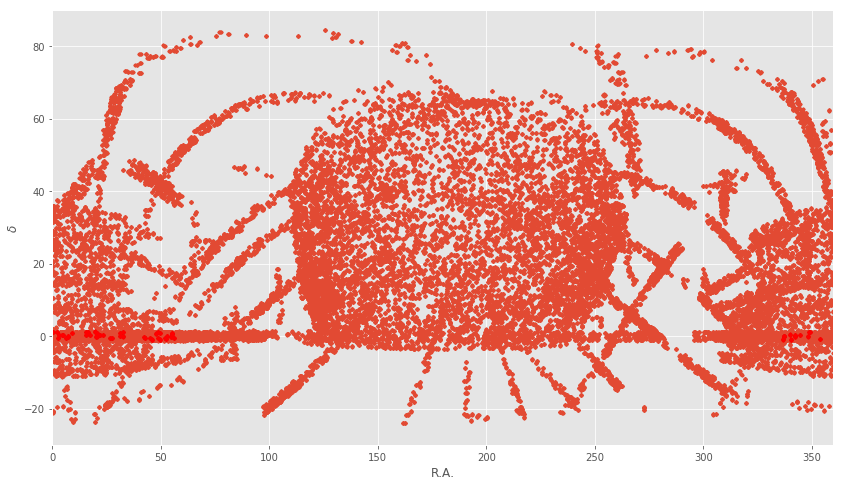

In [55]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(result.ra, result.dec, marker='.')

someRun = result[result.run == 94]
ax.scatter(someRun.ra, someRun.dec, color='r', marker='.')

ax.set_xlim(0, 360)
ax.set_ylim(-30, 90)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")